In [79]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [80]:
# read the main data set
df=pd.read_csv('estimation_file.csv',
                    encoding='utf-8')


/Users/rianajawad/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [82]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [83]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

In [84]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [85]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [86]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [87]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)
    

/Users/rianajawad/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rianajawad/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [88]:
# check the data
df.head()

Unnamed: 0   CBSA          UPT          VRM  \
ID                       Year                                                
Akron, OH Metro Area-Bus 2002           0  10420  5226385.660  4026372.388   
                         2003           1  10420  5395901.888  3976568.624   
                         2004           2  10420  5907162.281  4315392.555   
                         2005           3  10420  6013680.881  4053011.065   
                         2006           4  10420  6070797.419  3994786.013   

                                   UPT_ADJ      VRM_ADJ      VRH_ADJ  \
ID                       Year                                          
Akron, OH Metro Area-Bus 2002  5226385.660  4026372.388  270506.6928   
                         2003  5395901.888  3976568.624  270398.3688   
                         2004  5907162.281  4315392.555  597239.8605   
                         2005  6013680.881  4053011.065  281367.9792   
                         2006  6070797.419  3994786.013  281536.7841   

                               FARE_TOTAL  FARE_per_UPT  AREALANDPT  \
ID                       Year                                         
Akron, OH Metro Area-Bus 2002    660887.0      0.126452   744634347   
                         2003   2568502.0      0.476010   744634347   
                         2004   2524882.0      0.427427   744634347   
                         2005   3022880.0      0.502667   744634347   
                         2006   3163036.0      0.521025   744634347   

                                   Tot_Pop  Tot_Instate_Pop  Tot_Outstate_Pop  \
ID                       Year                                                   
Akron, OH Metro Area-Bus 2002  646583.7344      496141.0469       137193.6719   
                         2003  659397.0625      504631.8125       137582.3125   
                         2004  672492.7500      513183.7500       138058.7500   
                         2005  684459.0000      521491.0000       138184.0000   
                         2006  700943.0000      530777.0000       139714.0000   

                               Tot_NonUSA_POP  Total_Median_Income_Individual  \
ID                       Year                                                   
Akron, OH Metro Area-Bus 2002      -389.53125                     25405.20313   
                         2003       753.12500                     25120.18750   
                         2004      1942.50000                     24804.25000   
                         2005      2945.00000                     24612.00000   
                         2006      4695.00000                     23925.00000   

                               Native_Instate_Med_Inc_Indiv  \
ID                       Year                                 
Akron, OH Metro Area-Bus 2002                   26028.32813   
                         2003                   25632.68750   
                         2004                   25208.25000   
                         2005                   24899.00000   
                         2006                   24129.00000   

                               Native_Outstate_Med_Inc_Indiv  \
ID                       Year                                  
Akron, OH Metro Area-Bus 2002                    26651.07813   
                         2003                    25995.68750   
                         2004                    25305.25000   
                         2005                    24755.00000   
                         2006                    23644.00000   

                               Total_Pop_Poverty  Pop_Below100_Poverty  \
ID                       Year                                            
Akron, OH Metro Area-Bus 2002          682354.11                  7.55   
                         2003          682850.56                  8.81   
                         2004          683397.75                 10.08   
                         2005          683742.00                 11.30   
          

In [11]:
df.to_csv('temp.csv')

## Some core model specification tests

In [89]:
# no time trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6817
Estimator:                   PanelOLS   R-squared (Between):              0.8811
No. Observations:                4142   R-squared (Within):               0.6817
Date:                Thu, Nov 14 2019   R-squared (Overall):              0.8850
Time:                        22:44:27   Log-likelihood                    418.78
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1382.6
Entities:                         263   P-value                           0.0000
Avg Obs:                       15.749   Distribution:                  F(6,3873)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             1382.6
                            

/Users/rianajawad/anaconda3/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [90]:
# add time trend pivoting at 2010

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_2002_2014_BUS \
                    + YEARS_AFTER_2014_BUS \
                    + YEARS_2002_2014_RAIL \
                    + YEARS_AFTER_2014_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6990
Estimator:                   PanelOLS   R-squared (Between):              0.9843
No. Observations:                4142   R-squared (Within):               0.6990
Date:                Thu, Nov 14 2019   R-squared (Overall):              0.9856
Time:                        22:44:29   Log-likelihood                    534.49
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      898.56
Entities:                         263   P-value                           0.0000
Avg Obs:                       15.749   Distribution:                 F(10,3869)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             898.56
                            

## Run some analytics

In [91]:
# no time trends

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6817
Estimator:                   PanelOLS   R-squared (Between):              0.8811
No. Observations:                4142   R-squared (Within):               0.6817
Date:                Thu, Nov 14 2019   R-squared (Overall):              0.8850
Time:                        22:44:38   Log-likelihood                    418.78
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1382.6
Entities:                         263   P-value                           0.0000
Avg Obs:                       15.749   Distribution:                  F(6,3873)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             1382.6
                            

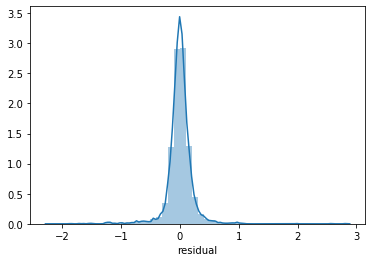

In [92]:
sns.distplot(res.resids)

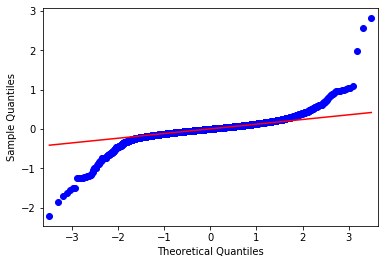

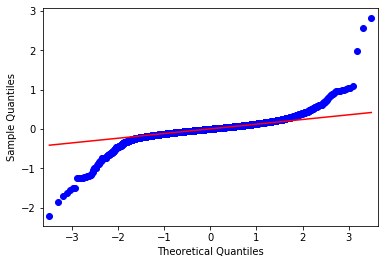

In [93]:
sm.graphics.qqplot(res.resids,line = 'q')

In [102]:
app_data

RAIL_FLAG  CLUSTER_APTA  CLUSTER_GT  \
ID                           Year                                        
Akron, OH Metro Area-Bus     2002          0            24           1   
                             2003          0            24           1   
                             2004          0            24           1   
                             2005          0            24           1   
                             2006          0            24           1   
...                                      ...           ...         ...   
Yuba City, CA Metro Area-Bus 2014          0            31           3   
                             2015          0            31           3   
                             2016          0            31           3   
                             2017          0            31           3   
                             2018          0            31           3   

                                   CLUSTER_APTA_HML  UPT_ADJ_log  VRM_ADJ_log  \
ID                           Year                                               
Akron, OH Metro Area-Bus     2002                 2    15.469231    15.208377   
                             2003                 2    15.501150    15.195930   
                             2004                 2    15.591676    15.277699   
                             2005                 2    15.609548    15.214971   
                             2006                 2    15.619001    15.200501   
...                                             ...          ...          ...   
Yuba City, CA Metro Area-Bus 2014                 3    14.013529    13.692596   
                             2015                 3    13.985201    13.714004   
                             2016                 3    13.875060    13.715595   
                             2017                 3    13.762558    13.694828   
                             2018                 3    13.713906    13.713159   

                                   FARE_per_UPT_log  POP_EMP_log  \
ID                           Year                                  
Akron, OH Metro Area-Bus     2002          0.119073    13.808216   
                             2003          0.389342    13.823451   
                             2004          0.355874    13.839439   
                             2005          0.407242    13.857195   
                             2006          0.419384    13.879496   
...                                             ...          ...   
Yuba City, CA Metro Area-Bus 2014          0.728021    12.360608   
                             2015          0.743748    12.372312   
                             2016          0.756757    12.379343   
                             2017          0.790213    12.396301   
                             2018          0.781729    12.406169   

                                   GasPrice_log  PCT_HH_NO_VEH  TSD_POP_PCT  \
ID                           Year                                             
Akron, OH Metro Area-Bus     2002      0.858662           8.60     0.185260   
                             2003      0.936093           8.20     0.180770   
                             2004      1.040277           7.79     0.176377   
                             2005      1.178655           7.47     0.172435   
                             2006      1.264127           6.85     0.167543   
...                                         ...            ...          ...   
Yuba City, CA Metro Area-Bus 2014      1.549688           6.42     0.098444   
                             2015      1.393766           7.97     0.094715   
                             2016      1.294727           7.25     0.092738   
                             2017      1.373716           7.67     0.092671   
                             2018      1.481605           7.81     0.092140   

                                   estimated_effects  residual     fitted  \
ID                          

## Calculate FAC

In [100]:
# keep the relevant fields in the data set
app_data = pd.concat([df[['RAIL_FLAG', 'CLUSTER_APTA', 'CLUSTER_GT', 'CLUSTER_APTA_HML']], 
                      res.model.dependent.dataframe, 
                      res.model.exog.dataframe, 
                      res.estimated_effects, 
                      res.resids], axis=1)


In [101]:
# calculate the fitted values
app_data['fitted'] = app_data['estimated_effects']
for var in res.params.keys(): 
    app_data['fitted'] = app_data['fitted'] + (res.params[var] * app_data[var])

# and check that we add up correctly
app_data['check_fitted'] = app_data['fitted'] + app_data['residual'] - app_data['UPT_ADJ_log']

In [106]:
# create the necessary columns

# dependents
app_data['UPT_ADJ']    = np.exp(app_data['UPT_ADJ_log']) - 1
app_data['fitted_exp'] = np.exp(app_data['fitted']) - 1

# linear versions of logged variables
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '')] = np.exp(app_data[var]) - 1              

# ratios and differences
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '_ratio')] = 1
    else: 
        app_data[var+'_diff'] = 0

# FAC multipliers
for var in res.params.keys(): 
    app_data[var+'_FAC_ratio'] = 1

app_data['UPT_ADJ_base'] = 0
app_data['UPT_ADJ_ratio'] = 1
app_data['fitted_exp_ratio'] = 1
app_data['UPT_ADJ_diff'] = 0
app_data['fitted_exp_diff'] = 0

In [109]:
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0)

    for year in years[1:]:       
        base_year = year-1
        
        for var in res.params.keys(): 
            # ratios and differences
            if '_log' in var: 
                out_var = var.replace('_log', '_ratio')
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 / app_data.loc[(id,base_year), var])
            else: 
                out_var = var+'_diff'                    
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 - app_data.loc[(id,base_year), var])

            # FAC multipliers
            app_data.loc[(id,year),var+'_FAC_ratio'] = np.exp(res.params[var] * (
                                                    app_data.loc[(id,year), var] 
                                                    - app_data.loc[(id,base_year), var]))

            # estimated effects (if time effects is zero, no change)
            app_data.loc[(id,year),'effects_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'estimated_effects'] 
                                                    - app_data.loc[(id,base_year), 'estimated_effects'])

            # residual
            app_data.loc[(id,year),'residual_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'residual'] 
                                                    - app_data.loc[(id,base_year), 'residual'])

        # observed and fitted changes            
        app_data.loc[(id,year),'UPT_ADJ_base'] = app_data.loc[(id,base_year),'UPT_ADJ']
        app_data.loc[(id,year),'UPT_ADJ_ratio'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 / app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_ratio'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 / app_data.loc[(id,base_year),'fitted_exp'])

        app_data.loc[(id,year),'UPT_ADJ_diff'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 - app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_diff'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 - app_data.loc[(id,base_year),'fitted_exp'])


/Users/rianajawad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/rianajawad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [110]:
# calculate the total change ratios

app_data['FAC_ratio'] = 1
for var in res.params.keys(): 
    app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data[var+'_FAC_ratio']
    
app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data['effects_FAC_ratio']

In [111]:
app_data

RAIL_FLAG  CLUSTER_APTA  CLUSTER_GT  \
ID                           Year                                        
Akron, OH Metro Area-Bus     2002          0            24           1   
                             2003          0            24           1   
                             2004          0            24           1   
                             2005          0            24           1   
                             2006          0            24           1   
...                                      ...           ...         ...   
Yuba City, CA Metro Area-Bus 2014          0            31           3   
                             2015          0            31           3   
                             2016          0            31           3   
                             2017          0            31           3   
                             2018          0            31           3   

                                   CLUSTER_APTA_HML  UPT_ADJ_log  VRM_ADJ_log  \
ID                           Year                                               
Akron, OH Metro Area-Bus     2002                 2    15.469231    15.208377   
                             2003                 2    15.501150    15.195930   
                             2004                 2    15.591676    15.277699   
                             2005                 2    15.609548    15.214971   
                             2006                 2    15.619001    15.200501   
...                                             ...          ...          ...   
Yuba City, CA Metro Area-Bus 2014                 3    14.013529    13.692596   
                             2015                 3    13.985201    13.714004   
                             2016                 3    13.875060    13.715595   
                             2017                 3    13.762558    13.694828   
                             2018                 3    13.713906    13.713159   

                                   FARE_per_UPT_log  POP_EMP_log  \
ID                           Year                                  
Akron, OH Metro Area-Bus     2002          0.119073    13.808216   
                             2003          0.389342    13.823451   
                             2004          0.355874    13.839439   
                             2005          0.407242    13.857195   
                             2006          0.419384    13.879496   
...                                             ...          ...   
Yuba City, CA Metro Area-Bus 2014          0.728021    12.360608   
                             2015          0.743748    12.372312   
                             2016          0.756757    12.379343   
                             2017          0.790213    12.396301   
                             2018          0.781729    12.406169   

                                   GasPrice_log  PCT_HH_NO_VEH  TSD_POP_PCT  \
ID                           Year                                             
Akron, OH Metro Area-Bus     2002      0.858662           8.60     0.185260   
                             2003      0.936093           8.20     0.180770   
                             2004      1.040277           7.79     0.176377   
                             2005      1.178655           7.47     0.172435   
                             2006      1.264127           6.85     0.167543   
...                                         ...            ...          ...   
Yuba City, CA Metro Area-Bus 2014      1.549688           6.42     0.098444   
                             2015      1.393766           7.97     0.094715   
                             2016      1.294727           7.25     0.092738   
                             2017      1.373716           7.67     0.092671   
                             2018      1.481605           7.81     0.092140   

                                   estimated_effects  residual     fitted  \
ID                          

In [112]:
# calculate the FAC
app_data['Total_FAC'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC'] = (app_data[var+'_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
    app_data['Total_FAC'] = app_data['Total_FAC'] + app_data[var+'_FAC']
app_data['effects_FAC'] = (app_data['effects_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
app_data['Total_FAC'] = app_data['Total_FAC'] + app_data['effects_FAC']

# scale the FAC
app_data['FAC_scale'] = app_data['fitted_exp_diff'] / app_data['Total_FAC']
app_data['FAC_scale'] = app_data['FAC_scale'].fillna(1)

app_data['Total_FAC_scaled'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC_scaled'] = app_data[var+'_FAC'] * app_data['FAC_scale']
    app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data[var+'_FAC_scaled']
app_data['effects_FAC_scaled'] = app_data[var+'_FAC_scaled'] * app_data['FAC_scale']
app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data['effects_FAC_scaled']


In [113]:
# reset the index so I get ID and year
app_data = app_data.reset_index()
app_data = app_data.rename(columns={'level_0' : 'ID', 'level_1' : 'Year'})
app_data.to_csv('FAC.csv')

In [119]:
# these are the fields we keep
out_fields = ['ID', 'Year', 'RAIL_FLAG', 
              'CLUSTER_APTA', 'CLUSTER_GT', 'CLUSTER_APTA_HML', 
              'UPT_ADJ_base', 'UPT_ADJ', 'UPT_ADJ_diff', 
              'fitted_exp', 'fitted_exp_diff']

# exogenous variables 
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    out_fields = out_fields + [out_var]
    
# FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC']
out_fields = out_fields + ['Total_FAC']
    
# scaled FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC_scaled']
out_fields = out_fields + ['Total_FAC_scaled']

# keep those fields
summary_data = app_data.reset_index()[out_fields]

In [115]:
# take weighted average of exogenous variables
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] * summary_data['UPT_ADJ_base']

# aggregate to bus/rail totals
summary_data = summary_data.groupby(by=['CLUSTER_GT', 'RAIL_FLAG', 'Year']).agg('sum')
summary_data_apta = summary_data.groupby(by=['CLUSTER_APTA', 'RAIL_FLAG', 'Year']).agg('sum')
summary_data_apta_hml = summary_data.groupby(by=['CLUSTER_APTA_HML', 'RAIL_FLAG', 'Year']).agg('sum')

# divide for weighted averages
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] / summary_data['UPT_ADJ_base']
    summary_data_apta[out_var] = summary_data_apta[out_var] / summary_data_apta['UPT_ADJ_base']
    summary_data_apta_hml[out_var] = summary_data_apta_hml[out_var] / summary_data_apta_hml['UPT_ADJ_base']
    

In [118]:
summary_data.to_csv('FAC_totals_GT_CLUSTERS.csv')

In [117]:
summary_data.head(20)

CLUSTER_APTA  CLUSTER_APTA_HML  UPT_ADJ_base  \
CLUSTER_GT RAIL_FLAG Year                                                 
1          0         2002          1090                99  0.000000e+00   
                     2003          1121               102  6.274237e+08   
                     2004          1210               110  6.263104e+08   
                     2005          1210               110  6.277594e+08   
                     2006          1210               110  6.472381e+08   
                     2007          1241               113  6.421027e+08   
                     2008          1241               113  6.509012e+08   
                     2009          1241               113  6.815643e+08   
                     2010          1241               113  6.507886e+08   
                     2011          1241               113  6.423078e+08   
                     2012          1241               113  6.524031e+08   
                     2013          1241               113  6.538212e+08   
                     2014          1241               113  6.438418e+08   
                     2015          1241               113  6.393489e+08   
                     2016          1241               113  6.192759e+08   
                     2017          1241               113  6.011069e+08   
                     2018          1241               113  5.684932e+08   
           1         2002           140                13  0.000000e+00   
                     2003           140                13  4.866284e+07   
                     2004           150                14  4.929762e+07   

                                UPT_ADJ  UPT_ADJ_diff    fitted_exp  \
CLUSTER_GT RAIL_FLAG Year                                             
1          0         2002  6.274237e+08  0.000000e+00  5.470306e+08   
                     2003  6.263104e+08 -3.614559e+06  5.694877e+08   
                     2004  6.277594e+08 -6.933612e+06  6.039488e+08   
                     2005  6.472381e+08  1.947872e+07  6.547201e+08   
                     2006  6.421027e+08 -5.135428e+06  6.580311e+08   
                     2007  6.509012e+08  5.693620e+06  6.663563e+08   
                     2008  6.815643e+08  3.066302e+07  6.919766e+08   
                     2009  6.507886e+08 -3.077564e+07  6.117998e+08   
                     2010  6.423078e+08 -8.480835e+06  6.316391e+08   
                     2011  6.524031e+08  1.009533e+07  6.662571e+08   
                     2012  6.538212e+08  1.418090e+06  6.589174e+08   
                     2013  6.438418e+08 -9.979458e+06  6.445888e+08   
                     2014  6.393489e+08 -4.492900e+06  6.479681e+08   
                     2015  6.192759e+08 -2.007296e+07  6.021329e+08   
                     2016  6.011069e+08 -1.816895e+07  5.852961e+08   
                     2017  5.684932e+08 -3.261377e+07  5.976908e+08   
                     2018  5.199746e+08 -4.844862e+07  5.746379e+08   
           1         2002  4.866284e+07  0.000000e+00  4.985213e+07   
                     2003  4.929762e+07  6.347854e+05  5.240687e+07   
                     2004  5.135395e+07 -8.824788e+05  5.829055e+07   

                           fitted_exp_diff       VRM_ADJ  FARE_per_UPT  \
CLUSTER_GT RAIL_FLAG Year                                                
1          0         2002     0.000000e+00           NaN           NaN   
                     2003     2.028682e+07  1.853744e+07      0.898461   
                     2004     2.684815e+07  1.827134e+07      0.816747   
                     2005     5.077133e+07  1.669588e+07      0.752877   
                     2006     3.310962e+06  1.662386e+07      0.848571   
                     2007     4.626137e+06  1.704944e+07      0.872266   
                     2008     2.562028e+07  1.673108e+07      0.891925   
                     2009    -8.017686e+07  1.671213e+07      0.962890   
                     2010     1.983930e+07  1.616478e+07      0.961608   